In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
!pip install import_ipynb 
!conda install -c conda-forge import_ipynb

/Users/gabesmithline/miniconda3/lib/python3.10/site-packages/conda/base/context.py:200: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - import_ipynb

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults
  - https://conda.anaconda.org/pytorch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at

In [139]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from prompts.make_prompt_bargain import make_prompt_bargain
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

In [140]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [141]:

import time
# prompt_style = 'llama_3.1_405b_maximize_value_outside_offer_example'
prompt_style = 'openai_4o_maximize_value_outside_offer_cot'
# prompt_style = 'bargain_maximize_results_outside_offer_emphasized_with_example'
# prompt_style = 'anthropic_3.5_sonnet_maximize_value_outside_offer_cot'
date = '12_12_2024'
max_rounds = 3

def calculate_discounted_value(offer, values, gamma, realization_round):
    """
    Calculate the discounted value of an offer.

    Parameters:
    - offer: List of item quantities.
    - values: List of item values for the player.
    - gamma: Discount factor.
    - realization_round: The round when the payoff is realized.
    """
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (realization_round - 1))

rounds = []
p1_values = []
p2_values = []
games = 100  

pathology_results = pd.DataFrame()
envy_results_history = {}

for i in range(games):
    if (i + 1) % 10 == 0:
        print(f"Game {i + 1} of {games}")
        time.sleep(2 * 60)  #Sleep for 2 minutes

    rounds = []
    p1_values = []
    p2_values = []
    p1_offers = []
    p2_offers = []

    game = NegotitaionGame(
        player1_agent=llm_agent.LLMAgent(llm_type="openai", player_num=0),
        player2_agent=llm_agent.LLMAgent(llm_type="openai", player_num=1),
        num_items=5,
        item_value_range=[1, 101],
        gamma=0.9,
        max_rounds=max_rounds,
        outside_offer_value_range=[1, 1000]
    )

    game_history = GameHistory(
        agent_1_name="Agent1",
        agent_2_name="Agent2",
        num_items=game.num_items,
        items=torch.tensor(game.items),
        agent_1_values=torch.tensor(game.player_values[0]),
        agent_2_values=torch.tensor(game.player_values[1]),
        agent_1_outside_value=game.outside_offer_values[0],
        agent_2_outside_value=game.outside_offer_values[1]
    )

    game_history.agent_1_offers = []
    game_history.agent_2_offers = []

    game.game_results = pd.DataFrame(columns=[  # Set up dataframe to store game pathology results
        "game_num", "round_num", "player", "discount_rate", "offer", "value", "items",
        "your_side_of_current_offer", "outside_offer", "accepting_an_offer_worse_than_outside_offer",
        "making_an_offer_worse_for_you_than_your_outside_offer",
        "walking_away_from_an_offer_better_than_your_outside_offer",
        "offer_no_items_or_all_items", "making_offer_worse_than_previous"
    ])

    while game.in_progress:
        current_step = len(game.history[0]) + len(game.history[1]) + 1
        current_round = (current_step - 1) // 2 + 1
        current_player = 1 if current_step % 2 == 1 else 2
        game.current_round = current_round
        your_side_of_current_offer = None
        '''
        PATHOLOGIES
        '''
        making_offer_worse_than_previous = False  # Only occurs in non-final rounds
        making_offer_worse_than_outside_offer = False  # Only occurs in non-final rounds
        offer_no_items_or_all_items = False  # Only occurs in non-final rounds
        accepting_an_offer_worse_than_outside_offer = False  # Only occurs in final round
        walking_away_from_an_offer_better_than_outside_offer = False  # Only occurs in final round

        print(f"\n{'=' * 80}")
        print(f"Game {i + 1}, Round {current_round}, Player {current_player}'s turn (Step {current_step})")
        print(f"{'=' * 80}")

        prev_offer = game.current_offer
        game.step()

        if game.current_offer: 

            if game.players[current_player - 1].action == "COUNTEROFFER":
                if current_player == 1:
                    realization_round_p1 = current_round
                    realization_round_p2 = current_round
                else:
                    realization_round_p1 = current_round + 1
                    realization_round_p2 = current_round + 1
            else:
                realization_round_p1 = current_round
                realization_round_p2 = current_round

            #calculate values with realization rounds
            p1_kept = game.items - np.array(game.current_offer.offer)
            p1_value = calculate_discounted_value(
                p1_kept, game.player_values[0], game.gamma, realization_round_p1
            )
            p2_value = calculate_discounted_value(
                game.current_offer.offer, game.player_values[1], game.gamma, realization_round_p2
            )

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            if current_player == 1:
                p1_offers.append(game.current_offer.offer)
            else:
                p2_offers.append(game.current_offer.offer)
                print(f"\nRound {current_round} Values:")
                print(f"Player 1: {p1_value:.2f}")
                print(f"Player 2: {p2_value:.2f}")

            '''
            PATHOLOGY 1: Immediate offer was worse than the offer you just rejected
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (game.current_round == 1 and current_player == 2) or game.current_round > 1:
                    if current_player == 1:
                        your_side_of_previous_offer = p1_values[-2]  #P1's value from P2's previous offer
                        your_side_of_current_offer = p1_values[-1]  #P1's value from the current offer
                    else:
                        your_side_of_previous_offer = p2_values[-2]  #P2's value from P1's previous offer
                        your_side_of_current_offer = p2_values[-1]  #P2's value from the current offer

                    if your_side_of_previous_offer > your_side_of_current_offer:
                        making_offer_worse_than_previous = True
                    else:
                        making_offer_worse_than_previous = False

                '''
                PATHOLOGY 2: Immediate offer was worse than your outside offer
                '''
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
            else:
                making_offer_worse_than_outside_offer = False

            '''
            PATHOLOGY 3: Offer had no items or all items
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (np.array_equal(game.current_offer.offer, [0] * game.num_items) or
                        np.array_equal(game.current_offer.offer, game.items)):
                    offer_no_items_or_all_items = True
                else:
                    offer_no_items_or_all_items = False

            '''
            PATHOLOGY 4: Accepting an offer worse than your outside offer
            '''
            if game.final_action_player.action == "ACCEPT":
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True

            '''
            PATHOLOGY 5: Walking away from an offer better than your outside offer
            '''
            if game.final_action_player.action == "WALK" or (
                    current_player == 2 and
                    game.players[current_player - 1].action == "COUNTEROFFER" and
                    game.current_round == game.max_rounds):
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True

            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": game.current_offer.offer,
                "value": p1_value if current_player == 1 else p2_value,
                "items": game.items,
                "your_side_of_current_offer": your_side_of_current_offer,
                "outside_offer": outside_offer,
                "accepting_an_offer_worse_than_outside_offer": accepting_an_offer_worse_than_outside_offer,
                "making_an_offer_worse_for_you_than_your_outside_offer": making_offer_worse_than_outside_offer,
                "walking_away_from_an_offer_better_than_your_outside_offer": walking_away_from_an_offer_better_than_outside_offer,
                "offer_no_items_or_all_items": offer_no_items_or_all_items,
                "making_offer_worse_than_previous": making_offer_worse_than_previous
            }])], ignore_index=True)

        '''
        FINAL POSSIBLE ROUND PRINT STATEMENTS
        '''
        if game.current_offer is not None and len(game.current_offer.offer) == game.num_items:
            
            game_history.add_offer(
                game.current_player,
                Offer(game.current_player, offer=torch.tensor(game.current_offer.offer))
            )

        if current_round == game.max_rounds and current_player == 2:
            if game.current_offer and game.current_offer != prev_offer:
                print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            elif game.current_offer == prev_offer:
                print("\nPlayer 2's final action: ACCEPT")
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(
                    p1_kept, game.player_values[0], game.gamma, current_round
                )
                p2_value = calculate_discounted_value(
                    game.current_offer.offer, game.player_values[1], game.gamma, current_round
                )
            else:
                
                print("\nPlayer 2's final action: WALK")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")

            game.in_progress = False
            print(f"\nRound {current_round} Final Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            break
        elif game.current_offer is None and current_player == 1 and game.final_action_player.action == "WALK":
            # If Player 1 makes an invalid offer
            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": [],
                "value": None,
                "items": game.items,
                "your_side_of_current_offer": None,
                "outside_offer": None,
                "accepting_an_offer_worse_than_outside_offer": None,
                "making_an_offer_worse_for_you_than_your_outside_offer": None,
                "walking_away_from_an_offer_better_than_your_outside_offer": None,
                "offer_no_items_or_all_items": None,
                "making_offer_worse_than_previous": None
            }])], ignore_index=True)
            game.in_progress = False

    pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)
    envy_results_history[i] = game_history

pathology_results.to_csv(f'pathology_results_{date}_{games}_{prompt_style}.csv', index=False)

# pd.DataFrame.from_dict(envy_results_history, orient='index').to_csv(
#     f'envy_results_{date}_{games}_{prompt_style}.csv', index=False
# )


Game 1, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 7 units of item 2, 0 units of item 3, 4 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 31 for item 1, 97 for item 2, 19 for item 3, 55 for item 4, 72 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 903. Your objective is to maximize your value of the outcome of the negotiation game. Remember, you have a guaranteed alternative: your outside offer.

    Before making any counteroffer, you should ca

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the optimal action, let's go through the process step by step:\n\n### Step 1: Analyze the Current Situation\n- **Outside Offer Value**: 683\n- **Item Values (per unit)**:\n  - Item 1: 90\n  - Item 2: 39\n  - Item 3: 58\n  - Item 4: 77\n  - Item 5: 93\n- **Current Offer**: None\n- **Round**: 1\n- **Discount Factor (Gamma)**: 0.9\n\n### Step 2: Calculate Values\n1. **Total Units Available**:\n   - Item 1: 3\n   - Item 2: 2\n   - Item 3: 13\n   - Item 4: 5\n   - Item 5: 4\n\n2. **Value Calculation for Counteroffer where Player 1 keeps most valuable items**:\n   - Let's consider an initial division where I get a larger share of more valuable items to ensure my offer has value exceeding my outside offer:\n     - Offer 0 units of Item 1: I get 3 units, value = 3 * 90 = 270\n     - Offer 1 unit of Item 2: I get 1 unit, value = 1 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:214: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, I will evaluate the potential value of each option:\n\n### Step 1: Current Situation\n- **My outside offer value:** 707\n- **My item values:** \n  - Item 1: 69\n  - Item 2: 30\n  - Item 3: 39\n  - Item 4: 73\n  - Item 5: 93\n- **Current offer:** [0, 1, 8, 2, 0]\n   - This means I would receive 0 of item 1, 1 of item 2, 8 of item 3, 2 of item 4, and 0 of item 5.\n- **Round and discount factor:** Round 1, with discount factor \\( \\gamma = 0.9 \\).\n\n### Step 2: Calculate Values\n**Value if I accept the current offer:**\n- 0 units of item 1: \\( 0 \\times 69 = 0 \\)\n- 1 unit of item 2: \\( 1 \\times 30 = 30 \\)\n- 8 units of item 3: \\( 8 \\times 39 = 312 \\)\n- 2 units of item 4: \\( 2 \\times 73 = 146 \\)\n- 0 units of item 5: \\( 0 \\times 93 = 0 \\)\n\n  **Total value if I accept:** \\( 0 + 30 + 312 + 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on my action, I'll start by considering the initial situation and my options for a counteroffer:\n\n### Step 1: Analysis of the Current Situation\n- **Outside Offer Value:** 971\n- **Item Values:**\n  - Item 1: 41\n  - Item 2: 13\n  - Item 3: 15\n  - Item 4: 23\n  - Item 5: 29\n- **Current Offer:** None\n- **Round and Discount Factor:** It is round 1 and the discount factor is 0.9.\n\n### Step 2: Calculation and Comparison\nSince there's no current offer on the table, I need to consider making a counteroffer. To ensure a counteroffer is better than my outside offer, I'll calculate values for potential divisions where my total portion exceeds 971.\n\n#### Example Counteroffer\nLet's consider a possible counteroffer where I receive most of the valuable items:\n- Offer to Player 2: [4, 5, 3, 3, 2]\n- Units I keep: [1, 0, 0, 1, 2

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide which action to take, I will follow the steps:\n\n### Step 1: Analyze the current situation\n\n- **My outside offer value**: 152\n- **My item values**: \n  - Item 1 = 8\n  - Item 2 = 97\n  - Item 3 = 5\n  - Item 4 = 99\n  - Item 5 = 70\n- **Current offer**: None\n- **Round**: 1\n- **Discount factor (gamma)**: 0.9\n\n### Step 2: Calculate potential offers\n\n**Note**: There is no current offer, so I need to make an initial offer.\n\n#### Consider possible offers:\n\nLet's consider the maximal value for me among possible counteroffers, ensuring the division is accepted given the constraints:\n\n1. **Offer the minimum value items to Player 2**:\n   \n   - I will prioritize keeping more units of items that have higher value to me. Based on value inclination, let's consider:\n     - Item 1: 1 unit available, I will keep 0 to avoid

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:214: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) Current Situation Analysis:\n- My outside offer value is 6.\n- My item values are 81 for item 1, 80 for item 2, 7 for item 3, 96 for item 4, 34 for item 5.\n- Current offer on the table is [0, 3, 3, 1, 1], meaning I receive 0 item 1, 3 item 2, 3 item 3, 1 item 4, and 1 item 5.\n- It is round 1, and the discount factor is 0.9.\n\n2) Value Calculation:\n- Current offer value if I accept:\n  - Item 1: 0 \u00d7 81 = 0\n  - Item 2: 3 \u00d7 80 = 240\n  - Item 3: 3 \u00d7 7 = 21\n  - Item 4: 1 \u00d7 96 = 96\n  - Item 5: 1 \u00d7 34 = 34\n  - Total value = 240 + 21 + 96 + 34 = 391\n  \n- The discount factor for round 1 is 0.9^0 = 1, so there is no discount applied.\n\n- Total value if I accept = 391 \u00d7 1 = 391\n\n3) Outcome Evaluation:\n- The value of the current offer to me (391) is much greater than my outside offer of 6.\n- The cur

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To proceed, let's follow the step-by-step plan:\n\n1) **Analyze the Current Situation:**\n   - My outside offer value is **405**.\n   - My item values:\n     - Item 1: 15 per unit\n     - Item 2: 41 per unit\n     - Item 3: 92 per unit\n     - Item 4: 83 per unit\n     - Item 5: 87 per unit\n   - There is no current offer on the table.\n   - We are in **round 1** with a discount factor (gamma) of **0.9**.\n\n2) **Calculations:**\n   - Calculate the value of potential counteroffers. I need to ensure the value of what I keep exceeds my outside offer of 405.\n   - The total available items are:\n     - 2 of item 1\n     - 3 of item 2\n     - 4 of item 3\n     - 7 of item 4\n     - 4 of item 5\n\n   Let's calculate a potential counteroffer where I keep valuable items to maximize my total value:\n\n   Trying to optimize my value:\n   - Keep

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:214: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the optimal action, I need to evaluate the current offer, potential counteroffers, and compare these with my outside offer value while considering the discount factor. Here's how I'll proceed:\n\n1) Analyzing the situation:\n   - My outside offer value is 398.\n   - My item values are: item 1 = 42, item 2 = 3, item 3 = 9, item 4 = 18, item 5 = 3.\n   - The current offer on the table, offered by Player 1 to me, is [2, 3, 3, 0, 0].\n   - We are in round 1 with a discount factor (gamma) of 0.9.\n\n2) Calculating the current offer's value:\n   - For me, the current offer gives:\n     - 2 units of item 1: 2 * 42 = 84\n     - 3 units of item 2: 3 * 3 = 9\n     - 3 units of item 3: 3 * 9 = 27\n     - 0 units of item 4: 0 * 18 = 0\n     - 0 units of item 5: 0 * 3 = 0\n   - Total value from accepting current offer: 84 + 9 + 27 + 0 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the situation and calculate what offers would be beneficial for me:\n\n1. **Outside Offer Value**: 977\n2. **Item Values**:\n   - Item 1: 4\n   - Item 2: 34\n   - Item 3: 70\n   - Item 4: 93\n   - Item 5: 42\n3. **Current Offer**: None\n4. **Round**: 1, Discount Factor (gamma): 0.9\n\nNow, I will calculate the total value I can get from different potential divisions, including any necessary discounting effect due to the rounds:\n\n**Evaluating Potential Counteroffers**:\n\nLet's examine a few possible counteroffers:\n\n- **Offer 1 (0, 0, 1, 0, 0)**: I keep most high-value items.\n\n  Calculation of my value:\n\n  Remaining for me:\n  - Item 1: 2 \u00d7 4 = 8 (since offer is 0 units)\n  - Item 2: 4 \u00d7 34 = 136 (since offer is 0 units)\n  - Item 3: 2 \u00d7 70 = 140 (since offer is 1 unit)\n  - Item 4: 4 \u00d7 93 = 372

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide my action, I will evaluate my potential total value for possible offers compared to my outside offer, factoring in the discount rate and round number.\n\n### Step-by-step Analysis:\n\n1) **Current Situation:**\n   - **Outside offer value:** 459\n   - **Item values:**\n     - Item 1: 90 per unit\n     - Item 2: 23 per unit (none available)\n     - Item 3: 55 per unit\n     - Item 4: 63 per unit\n     - Item 5: 15 per unit\n   - **Current offer:** None \n   - **Round:** 1\n   - **Discount factor (gamma):** 0.9\n\n2) **Calculation:**\n\n   Given there is no current offer, I need to consider making a counteroffer. I need to ensure my portion's value from the offer exceeds my outside offer value of 459.\n\n   Let's calculate possible desirable allocations to retain high-value items (those with a high value per unit).\n\n   - Total

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:214: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide the optimal action, let's break down the steps:\n\n1) **Current Situation:**\n   - Outside offer value: 345\n   - Item values:\n     - Item 1: 18\n     - Item 3: 24\n     - Item 4: 97\n     - Item 5: 16\n   - Current offer from Player 1: [1, 0, 2, 1, 0]\n   - Round: 1\n   - Discount factor: 1 (no discount in round 1)\n\n2) **Value Calculation:**\n   \n   **If I accept the current offer:**\n   - I receive 1 unit of item 1: 1 \u00d7 18 = 18\n   - I receive 2 units of item 3: 2 \u00d7 24 = 48\n   - I receive 1 unit of item 4: 1 \u00d7 97 = 97\n   - I receive 0 units of item 5: 0 \u00d7 16 = 0\n   - Total value to me: 18 + 48 + 97 + 0 = 163\n\n   My outside offer is 345, which is higher than 163, meaning accepting is not beneficial.\n\n   **Consider potential counteroffers:**\n   Trying to maximize my value over 345:\n   - Let's 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:214: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the current situation step by step:\n\n1) **Current Situation:**\n   - **Outside Offer Value:** 386.\n   - **Item Values:**\n     - Item 1: 24 per unit.\n     - Item 2: 79 per unit.\n     - Item 3: 3 per unit.\n     - Item 4: 47 per unit.\n     - Item 5: 68 per unit.\n   - **Current Offer:** [0, 3, 0, 1, 1] (this means I would receive 0 units of item 1, 3 units of item 2, 0 units of item 3, 1 unit of item 4, 1 unit of item 5).\n   - **Round:** 1.\n   - **Discount Factor:** 0.9.\n\n2) **Calculating Values:**\n   - **Value if I Accept the Current Offer:**\n     - 0 units of item 1 = 0 \u00d7 24 = 0.\n     - 3 units of item 2 = 3 \u00d7 79 = 237.\n     - 0 units of item 3 = 0 \u00d7 3 = 0.\n     - 1 unit of item 4 = 1 \u00d7 47 = 47.\n     - 1 unit of item 5 = 1 \u00d7 68 = 68.\n     - Total value from items = 237 + 47 + 68 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:214: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide my action, let's follow the outlined steps:\n\n### Current Situation\n1. **Outside Offer Value:** 308\n2. **My Item Values:**\n   - Item 1: 25\n   - Item 2: 19\n   - Item 3: 85\n   - Item 4: 89\n   - Item 5: 80\n3. **Current Offer:** [1, 1, 1, 2, 0] (the number of each item I would receive)\n4. **Round:** 1\n5. **Discount Factor (gamma):** 0.9\n\n### Value Calculation\n- **Value of Current Offer:**\n  - 1 unit of item 1: 1 * 25 = 25\n  - 1 unit of item 2: 1 * 19 = 19\n  - 1 unit of item 3: 1 * 85 = 85\n  - 2 units of item 4: 2 * 89 = 178\n  - 0 units of item 5: 0 * 80 = 0\n  - **Total current offer value:** 25 + 19 + 85 + 178 + 0 = 307\n\n#### Comparison:\n- **Value if Accept (discounted for round 1):** 307 * (0.9)^0 = 307\n- **Outside offer value:** 308\n\n### Evaluation\n1. **Accepting Current Offer:** Current value (307) i

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_10256/729552149.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


## Statistics of Play for Each Player Over Games

In [154]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()

    if is_game_ending_pathology:
        # Identify moves where the pathology occurred
        #pathology_moves = df[df[pathology_name]]
        pathology_moves = df[df[pathology_name].fillna(False)]

        # Get the first occurrence per game (since game ends after pathology)
        first_pathology_moves = pathology_moves.groupby('game_num').first().reset_index()

        # Overall count of games with the pathology
        overall_count = len(first_pathology_moves)

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {overall_count}/{total_games} ({(overall_count/total_games*100):.1f}%)")

        # Count per player
        player_counts = first_pathology_moves['player'].value_counts()

        for player in [1, 2]:
            player_count = player_counts.get(player, 0)
            print(f"Player {player}: {player_count}/{total_games} ({(player_count/total_games*100):.1f}%)")

        # Count per round
        round_counts = first_pathology_moves['round_num'].value_counts()
        for round_num in sorted(df['round_num'].unique()):
            round_count = round_counts.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_games} ({(round_count/total_games*100):.1f}%)")

    else:
        # Identify the first occurrence of a game-ending pathology per game
        game_ending_moves = df[df[['accepting_an_offer_worse_than_outside_offer',
                                   'walking_away_from_an_offer_better_than_your_outside_offer']].any(axis=1)]
        #first_game_ending_round = game_ending_moves.groupby('game_num')['round_num'].min()
        first_game_ending_indices = game_ending_moves.groupby('game_num').first().reset_index()['round_num']
        # Function to get valid moves (before any game-ending pathology occurs)
        def get_valid_moves(group):
            game_num = group['game_num'].iloc[0]
            if game_num in first_game_ending_indices.index:
                #pathology_round = first_game_ending_round.loc[game_num]
                first_pathology_index = first_game_ending_indices.loc[game_num]

                #return group[group['round_num'] < pathology_round]  # Exclude the pathology round and after
                return group[group['round_num'] < first_pathology_index]  # Exclude the pathology round and after
            else:
                return group  # Include all moves if no game-ending pathology occurred

        # Apply the function to get all valid moves before game-ending pathologies
        valid_moves = df.groupby('game_num').apply(get_valid_moves).reset_index(drop=True)

        total_moves = len(valid_moves)
        count = valid_moves[pathology_name].sum()

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {int(count)}/{total_moves} ({(count/total_moves*100):.1f}%)")

        # By Player
        for player in [1, 2]:
            player_moves = valid_moves[valid_moves['player'] == player]
            player_count = player_moves[pathology_name].sum()
            moves = len(player_moves)
            if moves > 0:
                print(f"Player {player}: {int(player_count)}/{moves} ({(player_count/moves*100):.1f}%)")

        # By Round
        for round_num in sorted(valid_moves['round_num'].unique()):
            round_moves = valid_moves[valid_moves['round_num'] == round_num]
            round_count = round_moves[pathology_name].sum()
            moves_in_round = len(round_moves)
            if moves_in_round > 0:
                print(f"Round {round_num}: {int(round_count)}/{moves_in_round} ({(round_count/moves_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 0/10 (0.0%)
Player 1: 0/10 (0.0%)
Player 2: 0/10 (0.0%)
Round 1: 0/10 (0.0%)
Round 2: 0/10 (0.0%)
Round 3: 0/10 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/10 (0.0%)
Player 1: 0/10 (0.0%)
Player 2: 0/10 (0.0%)
Round 1: 0/10 (0.0%)
Round 2: 0/10 (0.0%)
Round 3: 0/10 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 4/23 (17.4%)
Player 1: 0/15 (0.0%)
Player 2: 4/8 (50.0%)
Round 1: 3/15 (20.0%)
Round 2: 1/7 (14.3%)
Round 3: 0/1 (0.0%)

=== offer_no_items_or_all_items ===

Overall: 0/23 (0.0%)
Player 1: 0/15 (0.0%)
Player 2: 0/8 (0.0%)
Round 1: 0/15 (0.0%)
Round 2: 0/7 (0.0%)
Round 3: 0/1 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 6/23 (26.1%)
Player 1: 4/15 (26.7%)
Player 2: 2/8 (25.0%)
Round 1: 2/15 (13.3%)
Round 2: 4/7 (57.1%)
Round 3: 0/1 (0.0%)


In [143]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')
#df = pd.read_csv(f'../experiments/pathology_results_basic_11_11_2024_100_basic.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()
    
    if is_game_ending_pathology:
        # For game-ending pathologies, possible occurrences = total number of games
        total_possible_occurrences = total_games
        
        # Count games where the pathology occurred
        pathology_games = df[df[pathology_name].fillna(False)]['game_num'].nunique()
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {pathology_games}/{total_possible_occurrences} ({(pathology_games/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        pathology_games_by_player = df[df[pathology_name].fillna(False)].groupby('player')['game_num'].nunique()
        for player in [1, 2]:
            player_count = pathology_games_by_player.get(player, 0)
            print(f"Player {player}: {player_count}/{total_possible_occurrences} ({(player_count/total_possible_occurrences*100):.1f}%)")
        
        # Counts per round
        pathology_games_by_round = df[df[pathology_name].fillna(False)].groupby('round_num')['game_num'].nunique()
        for round_num in sorted(df['round_num'].unique()):
            round_count = pathology_games_by_round.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_possible_occurrences} ({(round_count/total_possible_occurrences*100):.1f}%)")
    else:
        total_steps = len(df) #total number of moves
        total_games = df['game_num'].nunique() #total number of games
        # For per-move pathologies, possible occurrences = total steps minus total games (assuming pathology cannot occur in the first move of each game)
        total_possible_occurrences = total_steps - total_games
        
        # Count steps where the pathology occurred
        pathology_occurrences = df[df[pathology_name].fillna(False)]
        total_pathology_occurrences = len(pathology_occurrences)
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {total_pathology_occurrences}/{total_possible_occurrences} ({(total_pathology_occurrences/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        for player in [1, 2]:
            player_occurrences = len(pathology_occurrences[pathology_occurrences['player'] == player])
            total_player_steps = len(df[df['player'] == player]) - total_games  # Subtract initial moves
            print(f"Player {player}: {player_occurrences}/{total_player_steps} ({(player_occurrences/total_player_steps*100):.1f}%)")
        
        # Counts per round
        for round_num in sorted(df['round_num'].unique()):
            if round_num == 1:
                # Subtract initial moves in round 1
                steps_in_round = len(df[df['round_num'] == round_num]) - total_games
            else:
                steps_in_round = len(df[df['round_num'] == round_num])
            round_occurrences = len(pathology_occurrences[pathology_occurrences['round_num'] == round_num])
            print(f"Round {round_num}: {round_occurrences}/{steps_in_round} ({(round_occurrences/steps_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 0/10 (0.0%)
Player 1: 0/10 (0.0%)
Player 2: 0/10 (0.0%)
Round 1: 0/10 (0.0%)
Round 2: 0/10 (0.0%)
Round 3: 0/10 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/10 (0.0%)
Player 1: 0/10 (0.0%)
Player 2: 0/10 (0.0%)
Round 1: 0/10 (0.0%)
Round 2: 0/10 (0.0%)
Round 3: 0/10 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 4/13 (30.8%)
Player 1: 0/5 (0.0%)
Player 2: 4/-2 (-200.0%)
Round 1: 3/5 (60.0%)
Round 2: 1/7 (14.3%)
Round 3: 0/1 (0.0%)

=== offer_no_items_or_all_items ===

Overall: 0/13 (0.0%)
Player 1: 0/5 (0.0%)
Player 2: 0/-2 (-0.0%)
Round 1: 0/5 (0.0%)
Round 2: 0/7 (0.0%)
Round 3: 0/1 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 6/13 (46.2%)
Player 1: 4/5 (80.0%)
Player 2: 2/-2 (-100.0%)
Round 1: 2/5 (40.0%)
Round 2: 4/7 (57.1%)
Round 3: 0/1 (0.0%)


## Compute Envy Free Results By Game

In [144]:
#Loop through envy_results_history and compute envy free results
envy_results_by_game = pd.DataFrame()
envy_results_by_game.columns = pd.DataFrame(columns=[ #Set up dataframe to store game pathology results
        "game_num", "outside_offer_consistency", "offer_increasing", "envy_free_strict", "envy_free_exclude_one_item"
    ])
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    evaluator = GameEvaluator(game)
    print(f"Outside offer consistency: {evaluator.evaluate_outside_offer_consistency()}")
    print(f"Offer increasing: {evaluator.evaluate_offer_increasing()}")
    print(f"Envy-free (strict): {evaluator.evaluate_envy_free()}")
    print(f"Envy-free (exclude one item): {evaluator.evaluate_envy_free(exclude_one_item=True)}")
    envy_results_by_game = pd.concat([envy_results_by_game, pd.DataFrame([{
        "game_num": i, "outside_offer_consistency": evaluator.evaluate_outside_offer_consistency(),
        "offer_increasing": evaluator.evaluate_offer_increasing(), "envy_free_strict": evaluator.evaluate_envy_free(),
        "envy_free_exclude_one_item": evaluator.evaluate_envy_free(exclude_one_item=True)
    }])], ignore_index=True)

#percentage of games that are envy free
print(f"Envy free (strict): {envy_results_by_game['envy_free_strict'].value_counts() / len(envy_results_by_game)}")
print(f"Envy free (exclude one item): {envy_results_by_game['envy_free_exclude_one_item'].value_counts() / len(envy_results_by_game)}")
print(f"Outside offer consistency: {envy_results_by_game['outside_offer_consistency'].value_counts() / len(envy_results_by_game)}")
print(f"Offer increasing: {envy_results_by_game['offer_increasing'].value_counts() / len(envy_results_by_game)}")



Game 1:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 2:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 3:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 4:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 5:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 6:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 7:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 8:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 9:
Outside

## Envy Free Results by Player

In [145]:
envy_results_history_copy = envy_results_history.copy()
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    print(f"Game History Values:")
    for player in [0, 1]:
        player_offers = game.get_offers(player)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        outside_value = game.agent_1_outside_value if player == 0 else game.agent_2_outside_value
        
        print(f"\nPlayer {player + 1}:")
        print(f"Outside offer value: {outside_value}")
        
        for i, offer in enumerate(player_offers):
            given_value = torch.dot(player_values, offer.offer)
            total_value = torch.dot(player_values, game.items)
            kept_value = total_value - given_value
            
            print(f"Offer {i + 1}:")
            print(f"  Offer: {offer.offer}")
            print(f"  Player values: {player_values}")
            print(f"  Value calculation:")
            print(f"    Total value: {total_value.item()} = {player_values} · {game.items}")
            print(f"    Given value: {given_value.item()} = {player_values} · {offer.offer}")
            print(f"    Kept value: {kept_value.item()} = {total_value.item()} - {given_value.item()}")
            print(f"  Value of kept items: {kept_value.item()}")

    print("\nEnvy-free evaluation details:")
    for player in [0, 1]:
        opponent = 1 - player
        player_offers = game.get_offers(player)
        opponent_offers = game.get_offers(opponent)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        
        print(f"\nPlayer {player + 1}:")
        for i, offer in enumerate(player_offers):
            if i < len(opponent_offers):
                opp_offer = opponent_offers[i]
                player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                
                print(f"Round {i + 1}:")
                print(f"  Player's offer: {offer.offer}")
                print(f"  Opponent's offer: {opp_offer.offer}")
                print(f"  Player's bundle value: {player_bundle_value.item()} = {player_values} · ({game.items} - {offer.offer})")
                print(f"  Opponent's bundle value (to player): {opponent_bundle_value.item()} = {player_values} · ({game.items} - {opp_offer.offer})")
                
                if player_bundle_value >= opponent_bundle_value:
                    print("  Envy-free: Yes")
                else:
                    print("  Envy-free: No")
                    print("  Checking if removing one item makes it envy-free:")
                    for j in range(len(game_history.items)):
                        temp_opp_offer = opp_offer.offer.clone()
                        if temp_opp_offer[j] > 0:
                            temp_opp_offer[j] -= 1
                            temp_opponent_bundle_value = torch.dot(player_values, game.items - temp_opp_offer)
                            print(f"    Removing item {j + 1}: {temp_opponent_bundle_value.item()} = {player_values} · ({game.items} - {temp_opp_offer})")
                            if player_bundle_value >= temp_opponent_bundle_value:
                                print(f"    Envy-free after removing item {j + 1}: Yes")
                                break
                    else:
                        print("    Envy-free after removing any single item: No")


Game 1:
Game History Values:

Player 1:
Outside offer value: 903

Player 2:
Outside offer value: 650

Envy-free evaluation details:

Player 1:

Player 2:
Game 2:
Game History Values:

Player 1:
Outside offer value: 683
Offer 1:
  Offer: tensor([1, 0, 8, 1, 1])
  Player values: tensor([90, 39, 58, 77, 93])
  Value calculation:
    Total value: 1859 = tensor([90, 39, 58, 77, 93]) · tensor([ 3,  2, 13,  5,  4])
    Given value: 724 = tensor([90, 39, 58, 77, 93]) · tensor([1, 0, 8, 1, 1])
    Kept value: 1135 = 1859 - 724
  Value of kept items: 1135

Player 2:
Outside offer value: 707
Offer 1:
  Offer: tensor([0, 1, 8, 2, 0])
  Player values: tensor([69, 30, 39, 73, 93])
  Value calculation:
    Total value: 1511 = tensor([69, 30, 39, 73, 93]) · tensor([ 3,  2, 13,  5,  4])
    Given value: 488 = tensor([69, 30, 39, 73, 93]) · tensor([0, 1, 8, 2, 0])
    Kept value: 1023 = 1511 - 488
  Value of kept items: 1023
Offer 2:
  Offer: tensor([2, 1, 5, 1, 3])
  Player values: tensor([69, 30, 39, 

In [146]:
print("Checking envy_results_history structure:")
print(f"Type: {type(envy_results_history_copy.items())}")
print(f"Length: {len(envy_results_history_copy.items())}")
if len(envy_results_history_copy.items()) > 0:
    first_game = next(iter(envy_results_history_copy.items()))[1]
    print("\nFirst game attributes:")
    print(f"Has items: {hasattr(first_game, 'items')}")
    print(f"Has agent_1_values: {hasattr(first_game, 'agent_1_values')}")
    print(f"Has agent_1_outside_value: {hasattr(first_game, 'agent_1_outside_value')}")
    print(f"Has get_offers method: {hasattr(first_game, 'get_offers')}")
    if hasattr(first_game, 'get_offers'):
        print(f"Number of offers player 1: {len(first_game.get_offers(0))}")
        print(f"Number of offers player 2: {len(first_game.get_offers(1))}")

Checking envy_results_history structure:
Type: <class 'dict_items'>
Length: 10

First game attributes:
Has items: True
Has agent_1_values: True
Has agent_1_outside_value: True
Has get_offers method: True
Number of offers player 1: 0
Number of offers player 2: 0


In [147]:
#TODO: Move this to metrics/envy_free_analysis.py
def analyze_envy_freeness_comprehensive(game_history):
    total_games = len(game_history)
    moves_data = []
    game_properties = []
    
    for game_id, game in game_history.items():
        evaluator = GameEvaluator(game)
        max_round = max(len(game.get_offers(0)), len(game.get_offers(1)))
        
        # Track game-level properties
        is_outside_consistent = evaluator.evaluate_outside_offer_consistency()
        is_offer_increasing = evaluator.evaluate_offer_increasing()
        is_final_allocation = evaluator.evaluate_envy_free()
        is_final_one_item_ef = evaluator.evaluate_envy_free(exclude_one_item=True)
        
        game_properties.append({
            'game_num': game_id,
            'rounds_played': max_round,
            'outside_consistent': is_outside_consistent,
            'offer_increasing': is_offer_increasing
        })
        
        for round_num in range(max_round):
            steps_in_round = 0
            for player in [0, 1]:
                opponent = 1 - player
                player_offers = game.get_offers(player)
                opponent_offers = game.get_offers(opponent)
                
                is_last_step = (round_num == max_round - 1 and 
                              round_num >= len(opponent_offers) - 1)
                
                if round_num < len(player_offers):
                    steps_in_round += 1
                    player_values = game.agent_1_values if player == 0 else game.agent_2_values
                    offer = player_offers[round_num]
                    
                    if round_num < len(opponent_offers):
                        opp_offer = opponent_offers[round_num]
                        player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                        opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                        
                        is_strict_ef = bool(player_bundle_value >= opponent_bundle_value)
                        is_one_item_ef = False
                        
                        if not is_strict_ef:
                            for j in range(len(game.items)):
                                temp_opp_offer = opp_offer.offer.clone()
                                if temp_opp_offer[j] > 0:
                                    temp_opp_offer[j] -= 1
                                    temp_value = torch.dot(player_values, game.items - temp_opp_offer)
                                    if player_bundle_value >= temp_value:
                                        is_one_item_ef = True
                                        break
                        
                        moves_data.append({
                            'game_num': game_id,
                            'round_num': round_num + 1,
                            'step_num': steps_in_round,
                            'player': player + 1,
                            'is_strict_ef': is_strict_ef,
                            'is_one_item_ef': is_one_item_ef,
                            'is_final_allocation': is_last_step,
                            'final_strict_ef': is_final_allocation if is_last_step else False,
                            'final_one_item_ef': is_final_one_item_ef if is_last_step else False,
                            'outside_consistent': is_outside_consistent,
                            'offer_increasing': is_offer_increasing
                        })
    
    df = pd.DataFrame(moves_data)
    game_props_df = pd.DataFrame(game_properties)
    
    def print_stats(group, name):
        strict_ef_count = group['is_strict_ef'].sum()
        one_item_ef_count = group['is_one_item_ef'].sum()
        outside_consistent_count = group['outside_consistent'].sum()
        offer_increasing_count = group['offer_increasing'].sum()
        count = len(group)
        
        print(f"\n=== {name} ===")
        print(f"Count: {count}")
        print(f"Strict Envy-Free: {strict_ef_count}/{count} ({(strict_ef_count/count*100):.1f}%)")
        print(f"One-Item Envy-Free: {one_item_ef_count}/{count} ({(one_item_ef_count/count*100):.1f}%)")
        print(f"Outside Offer Consistent: {outside_consistent_count}/{count} ({(outside_consistent_count/count*100):.1f}%)")
        print(f"Offer Increasing: {offer_increasing_count}/{count} ({(offer_increasing_count/count*100):.1f}%)")
    
    print("\nGAME LENGTH STATISTICS")
    print(f"Average rounds per game: {game_props_df['rounds_played'].mean():.1f}")
    print(f"Max rounds in any game: {game_props_df['rounds_played'].max()}")
    print(f"Min rounds in any game: {game_props_df['rounds_played'].min()}")
    
    # Overall game properties
    print("\nOVERALL GAME PROPERTIES")
    print(f"Outside Offer Consistent: {game_props_df['outside_consistent'].sum()}/{total_games} ({(game_props_df['outside_consistent'].sum()/total_games*100):.1f}%)")
    print(f"Offer Increasing: {game_props_df['offer_increasing'].sum()}/{total_games} ({(game_props_df['offer_increasing'].sum()/total_games*100):.1f}%)")
    
    # Overall statistics
    print("\nOVERALL STATISTICS")
    print(f"Total Games: {total_games}")
    print(f"Total Moves: {len(df)}")
    
    # Final allocation statistics
    final_moves = df[df['is_final_allocation']]
    final_strict = final_moves.groupby('game_num')['final_strict_ef'].any()
    final_one_item = final_moves.groupby('game_num')['final_one_item_ef'].any()
    
    print("\nFINAL ALLOCATION STATISTICS")
    print(f"Strict Envy-Free: {final_strict.sum()}/{total_games} ({(final_strict.sum()/total_games*100):.1f}%)")
    print(f"One-Item Envy-Free: {final_one_item.sum()}/{total_games} ({(final_one_item.sum()/total_games*100):.1f}%)")
    
    # By Player
    for player in [1, 2]:
        player_moves = df[df['player'] == player]
        print_stats(player_moves, f"Player {player}")
    
    # By Round
    for round_num in sorted(df['round_num'].unique()):
        round_moves = df[df['round_num'] == round_num]
        print_stats(round_moves, f"Round {round_num}")
        
        # By Step within Round
        for step_num in sorted(round_moves['step_num'].unique()):
            step_moves = round_moves[round_moves['step_num'] == step_num]
            print_stats(step_moves, f"Round {round_num} - Step {step_num}")
        
        # By Player within Round
        for player in [1, 2]:
            player_round_moves = round_moves[round_moves['player'] == player]
            print_stats(player_round_moves, f"Round {round_num} - Player {player}")

    return df

envy_stats_df = analyze_envy_freeness_comprehensive(envy_results_history_copy)  
#save to csv
envy_stats_df.to_csv(f'envy_stats_df_{date}_{games}_{prompt_style}.csv', index=False)



GAME LENGTH STATISTICS
Average rounds per game: 1.1
Max rounds in any game: 3
Min rounds in any game: 0

OVERALL GAME PROPERTIES
Outside Offer Consistent: 9/10 (90.0%)
Offer Increasing: 10/10 (100.0%)

OVERALL STATISTICS
Total Games: 10
Total Moves: 16

FINAL ALLOCATION STATISTICS
Strict Envy-Free: 3/10 (30.0%)
One-Item Envy-Free: 3/10 (30.0%)

=== Player 1 ===
Count: 8
Strict Envy-Free: 5/8 (62.5%)
One-Item Envy-Free: 0/8 (0.0%)
Outside Offer Consistent: 8/8 (100.0%)
Offer Increasing: 8/8 (100.0%)

=== Player 2 ===
Count: 8
Strict Envy-Free: 6/8 (75.0%)
One-Item Envy-Free: 0/8 (0.0%)
Outside Offer Consistent: 8/8 (100.0%)
Offer Increasing: 8/8 (100.0%)

=== Round 1 ===
Count: 10
Strict Envy-Free: 6/10 (60.0%)
One-Item Envy-Free: 0/10 (0.0%)
Outside Offer Consistent: 10/10 (100.0%)
Offer Increasing: 10/10 (100.0%)

=== Round 1 - Step 1 ===
Count: 5
Strict Envy-Free: 3/5 (60.0%)
One-Item Envy-Free: 0/5 (0.0%)
Outside Offer Consistent: 5/5 (100.0%)
Offer Increasing: 5/5 (100.0%)

=== Ro

## Statistics 

In [148]:
# Statistics of Envy Free Results
import pandas as pd
import torch
def compute_statistics(envy_results_history):
    # Initialize dictionaries to store statistics
    game_stats = []
    round_stats = []
    player_stats = []
    
    print(f"Number of games in history: {len(envy_results_history)}")  # Debug print
    
    for game_id, game in envy_results_history.items():
        print(f"Processing game {game_id + 1}")  # Debug print
        
        # Game level statistics
        game_data = {
            'game_id': game_id + 1,
            'total_rounds': len(game.get_offers(0)),
            'player1_outside_value': game.agent_1_outside_value,
            'player2_outside_value': game.agent_2_outside_value,
            'total_items': len(game.items)
        }
        game_stats.append(game_data)
        
        # Process each player's offers and values
        for player in [0, 1]:
            player_offers = game.get_offers(player)
            player_values = game.agent_1_values if player == 0 else game.agent_2_values
            opponent = 1 - player
            opponent_offers = game.get_offers(opponent)
            
            print(f"  Player {player + 1} has {len(player_offers)} offers")  # Debug print
            
            # Player level statistics
            player_data = {
                'game_id': game_id + 1,
                'player_id': player + 1,
                'total_value': torch.dot(player_values, game.items).item(),
                'outside_value': game.agent_1_outside_value if player == 0 else game.agent_2_outside_value,
                'num_offers': len(player_offers)
            }
            player_stats.append(player_data)
            
            # Round level statistics
            for round_id, (offer, opp_offer) in enumerate(zip(player_offers, opponent_offers)):
                given_value = torch.dot(player_values, offer.offer).item()
                kept_value = torch.dot(player_values, game.items - offer.offer).item()
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer).item()
                
                is_envy_free = kept_value >= opponent_bundle_value
                
                round_data = {
                    'game_id': game_id + 1,
                    'round_id': round_id + 1,
                    'player_id': player + 1,
                    'given_value': given_value,
                    'kept_value': kept_value,
                    'opponent_bundle_value': opponent_bundle_value,
                    'is_envy_free': is_envy_free
                }
                round_stats.append(round_data)
    
    print(f"\nStatistics summary:")  # Debug prints
    print(f"Number of game records: {len(game_stats)}")
    print(f"Number of player records: {len(player_stats)}")
    print(f"Number of round records: {len(round_stats)}")
    
    # Convert to DataFrames and save to CSV
    game_df = pd.DataFrame(game_stats)
    round_df = pd.DataFrame(round_stats)
    player_df = pd.DataFrame(player_stats)
    
    # Save to CSV files
    game_df.to_csv('game_statistics.csv', index=False)
    round_df.to_csv('round_statistics.csv', index=False)
    player_df.to_csv('player_statistics.csv', index=False)
    
    # Print first few rows of each DataFrame
    print("\nFirst few rows of game statistics:")
    print(game_df.head())
    print("\nFirst few rows of player statistics:")
    print(player_df.head())
    print("\nFirst few rows of round statistics:")
    print(round_df.head())
    
    return game_df, round_df, player_df

game_df, round_df, player_df = compute_statistics(envy_results_history)


Number of games in history: 10
Processing game 1
  Player 1 has 0 offers
  Player 2 has 0 offers
Processing game 2
  Player 1 has 1 offers
  Player 2 has 2 offers
Processing game 3
  Player 1 has 0 offers
  Player 2 has 0 offers
Processing game 4
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 5
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 6
  Player 1 has 0 offers
  Player 2 has 0 offers
Processing game 7
  Player 1 has 2 offers
  Player 2 has 3 offers
Processing game 8
  Player 1 has 2 offers
  Player 2 has 2 offers
Processing game 9
  Player 1 has 2 offers
  Player 2 has 2 offers
Processing game 10
  Player 1 has 0 offers
  Player 2 has 0 offers

Statistics summary:
Number of game records: 10
Number of player records: 20
Number of round records: 16

First few rows of game statistics:
   game_id  total_rounds  player1_outside_value  player2_outside_value  \
0        1             0                    903                    650   
1        2         

In [149]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



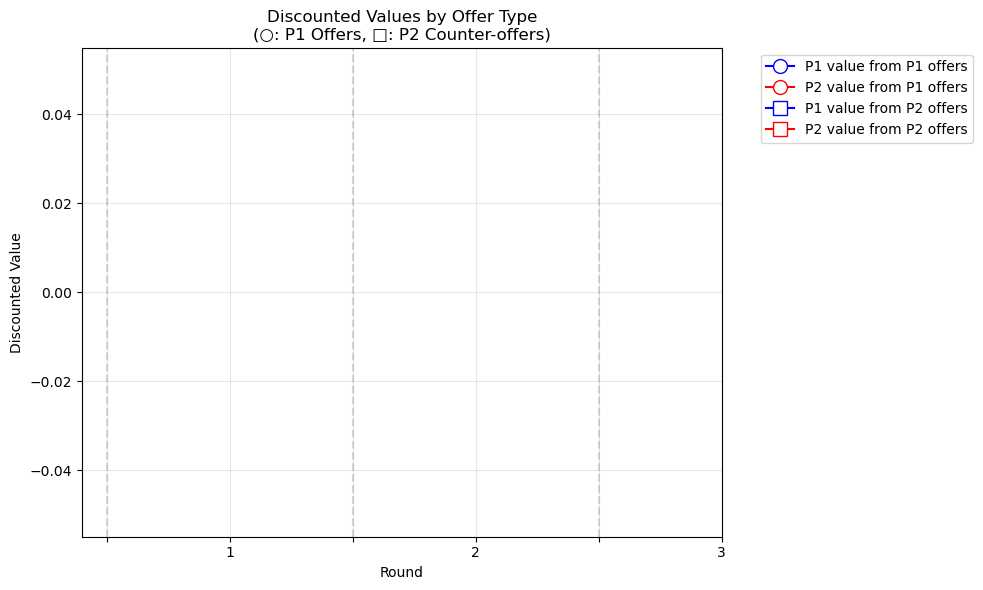

In [150]:
plot_discounted_values(rounds, p1_values, p2_values, max_rounds)


## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 0
Number of P1 offers: 0
Number of P2 offers: 0


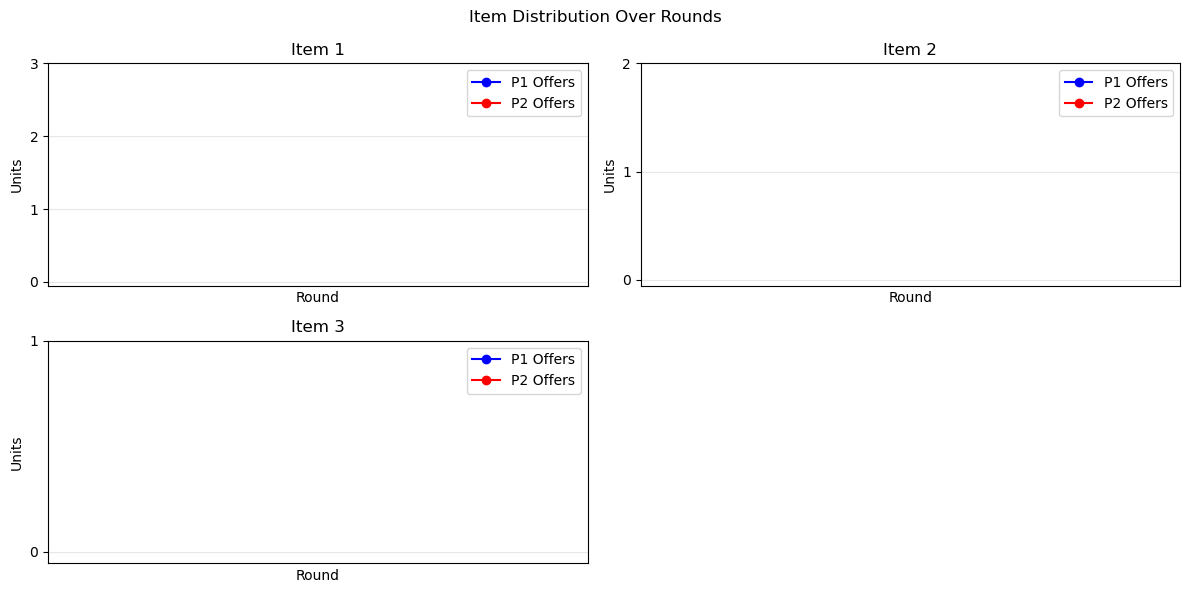

In [151]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

In [152]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")

RuntimeError: dot : expected both vectors to have same dtype, but found Float and Long

## Check Pathologies
- Check if Pathologies Occured
- Check Count in game 
- Save to csv
